In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

Print top 5 rows

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [4]:
def plot_timeseries(df):
    return df.plot()

Plot the timeseries from above

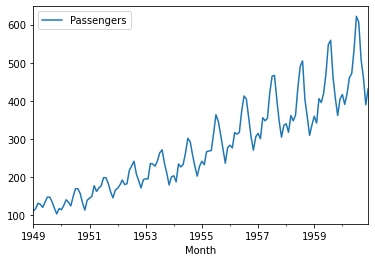

In [5]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [49]:
rolling = df.rolling(window=2,center=True)
rolling_mean = rolling.mean()
rolling_std=rolling.std()
rolls=pd.concat([rolling_mean,rolling_std],axis=1,ignore_index=True)


In [50]:
rolls.columns=['rolling_mean','rolling_std']

Plot two timeseries:
- with rolling mean 
- with rolling std

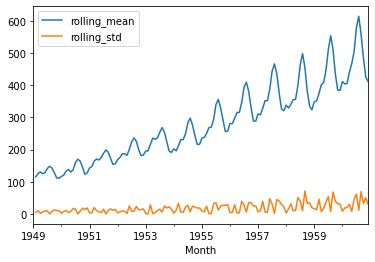

In [51]:
plot_timeseries(rolls)
plt.legend(['rolling_mean', 'rolling_std'],
           loc='upper left');

Test the stationarity of all timeseries

In [56]:
def ADF_Stationarity_Test(timeseries,significance_level):
    '''prints adfuller test results
prints the conclusion stating whether timeseries is stationary based on the siginificance level (input parameter of function)'''
    X=pd.Series(timeseries).fillna(method='ffill')
    X=pd.Series(timeseries).fillna(method='bfill')
    result = adfuller(X)
    if result[1]<significance_level:
        explain=print("reject the null hypothesis: This dataset IS stationary, p value is",
                      result[1],". AD Fuller value is",result[0])
    else:
        explain=print("DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is",
                      result[1],". AD Fuller value is",result[0])
    return explain


#### NOTE - the other way to check would be to have significance level be "1%,5%,10%" as strings, 
#and then check if the ADF statistic is LESS than the result[4][sig_level]. If it is less, the data is stationary,
# and you reject the null hypoth

# EXAMPLE:

# ADF Statistic: -0.444718
# p-value: 0.902360
# 	1%: -3.508
# 	5%: -2.895
# 	10%: -2.585

# For all three sig levels (1,5,10%) the ADF statistic is more than them so we CANNOT reject hte null 
#hypoth and this data is NOT STATIONARY

In [57]:
ADF_Stationarity_Test(rolls['rolling_mean'],0.05)

DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is 0.9920918197397876 . AD Fuller value is 0.8291100323878595


In [58]:
ADF_Stationarity_Test(rolls['rolling_std'],0.05)

DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is 0.9898778389143496 . AD Fuller value is 0.7020070600184805


Transform the original timeseries with logarithm

In [72]:
rolls['rolling_mean']=pd.Series(rolls['rolling_mean']).fillna(method='ffill')
rolls['rolling_mean']=pd.Series(rolls['rolling_mean']).fillna(method='bfill')
rolls['rolling_std']=pd.Series(rolls['rolling_std']).fillna(method='ffill')
rolls['rolling_std']=pd.Series(rolls['rolling_std']).fillna(method='bfill')


In [73]:
rolls=rolls.drop(['log_roll_mean','log_roll_std'],axis=1)

In [78]:
rolls['rolling_std']=rolls['rolling_std'].replace(0,0.1)

In [79]:
rolls['log_roll_mean']=np.log(rolls['rolling_mean'])
rolls['log_roll_std']=np.log(rolls['rolling_std'])

Plot transformed timeseries

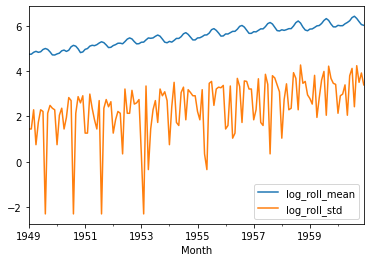

In [81]:
plot_timeseries(rolls[['log_roll_mean','log_roll_std']])

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [83]:
ADF_Stationarity_Test(rolls['log_roll_std'],0.05)

DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is 0.7421754722219116 . AD Fuller value is -1.0299743973694302


In [82]:
ADF_Stationarity_Test(rolls['log_roll_mean'],0.05)

DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is 0.3129366970738522 . AD Fuller value is -1.9411947885891163


In [84]:
rolls['mean_diff']=rolls['log_roll_mean']-rolls['log_roll_mean'].shift(1)

In [85]:
rolls['mean_std']=rolls['log_roll_std']-rolls['log_roll_std'].shift(1)

In [89]:
rolls=rolls.rename(columns={'mean_std':'std_diff'})

In [86]:
ADF_Stationarity_Test(rolls['mean_diff'],0.05)

reject the null hypothesis: This dataset IS stationary, p value is 0.011196967978844256 . AD Fuller value is -3.3930823071575023


In [90]:
ADF_Stationarity_Test(rolls['std_diff'],0.05)

reject the null hypothesis: This dataset IS stationary, p value is 1.3205741997386339e-05 . AD Fuller value is -5.112894509430747


Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

### Not optimal values, just an attempt

In [91]:
from statsmodels.tsa.arima_model import ARIMA

                             ARIMA Model Results                              
Dep. Variable:            D.mean_diff   No. Observations:                  142
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 195.773
Method:                       css-mle   S.D. of innovations              0.061
Date:                Tue, 15 Sep 2020   AIC                           -377.545
Time:                        09:30:25   BIC                           -356.855
Sample:                    03-01-1949   HQIC                          -369.138
                         - 12-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0003      0.003     -0.108      0.914      -0.006       0.006
ar.L1.D.mean_diff     0.2544      0.084      3.034      0.002       0.090       0.419
ar.L2.D.mean_diff    -0.

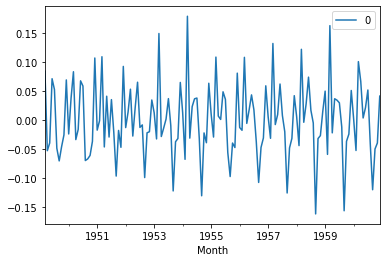

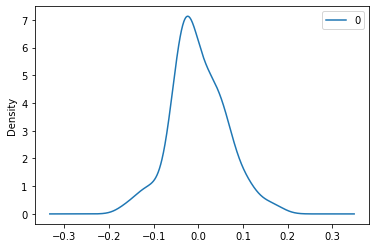

                0
count  142.000000
mean     0.000162
std      0.061153
min     -0.162106
25%     -0.037019
50%     -0.008443
75%      0.037502
max      0.178503


In [98]:
# fit model
model = ARIMA(rolls['mean_diff'].dropna(), order=(5,1,0),freq='MS')
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Plot the predictions (not transformed to the original scale)

In [100]:
from sklearn.metrics import mean_squared_error

In [101]:
series=rolls['mean_diff'].dropna()
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=-0.054875, expected=0.000000
predicted=0.067653, expected=0.073489
predicted=0.017482, expected=-0.008084
predicted=-0.069450, expected=0.064437
predicted=0.072828, expected=0.069094
predicted=-0.015926, expected=-0.001421
predicted=0.047731, expected=0.100083
predicted=0.118797, expected=0.132405
predicted=0.066147, expected=0.049488
predicted=0.069414, expected=-0.067691
predicted=-0.095619, expected=-0.148236
predicted=-0.104651, expected=-0.141361
predicted=-0.056131, expected=-0.017015
predicted=0.047309, expected=0.053164
predicted=0.013509, expected=-0.026988
predicted=-0.090760, expected=0.032888
predicted=0.045051, expected=0.043172
predicted=-0.031148, expected=0.001407
predicted=0.049313, expected=0.115436
predicted=0.126700, expected=0.148766
predicted=0.076013, expected=0.072873
predicted=0.080215, expected=-0.091402
predicted=-0.140550, expected=-0.175087
predicted=-0.099144, expected=-0.131474
predicted=-0.046461, expected=-0.033438
predicted=0.026272, expected

NameError: name 'pyplot' is not defined

## Tuning p,c,d
https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

### Analyze the result
To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.

NormaltestResult(statistic=2.3510823382469317, pvalue=0.3086519016043002)


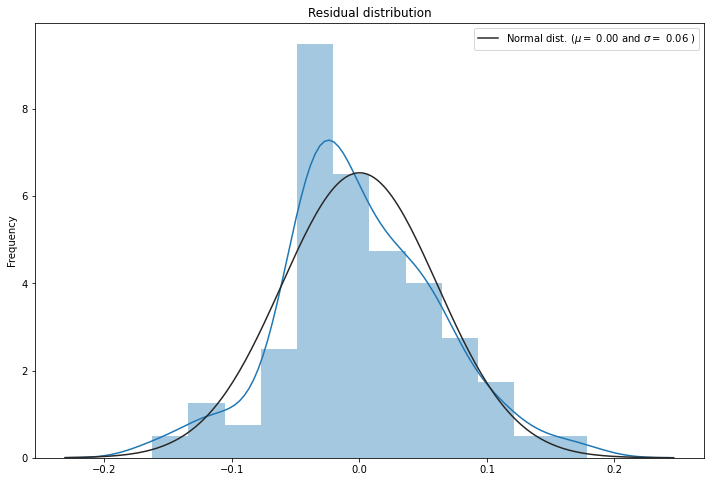

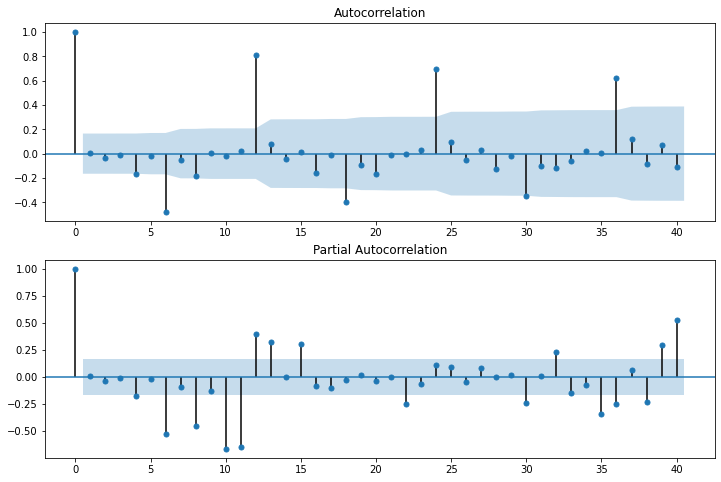

In [119]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns
import statsmodels.api as sm

resid = model_fit.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=40, ax=ax2)

## I think this means my model is good?

## optimizing values

????

Plot the predictions (transformed to the original scale)

In [113]:
trans_test = np.exp(test.cumsum())
trans_pred =np.exp(np.array(predictions).cumsum())

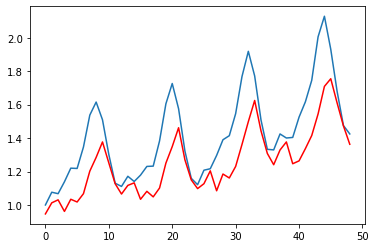

In [114]:
# plot
plt.plot(trans_test)
plt.plot(trans_pred, color='red')
plt.show()

Plot the predictions for the next 10 years